# Potato Leaf Disease Classification Using Deep Learning by Galav Bhatt

#### Import the Required Models

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

#### Specification of certain generalized parameters which will go through Data Preprocessing and Model Building

In [33]:
img_size = 256 
Batch_size = 32
epochs = 30
rgb_channel = 3

#### Now we will generate a tf.data.Dataset from image files in a directory

tf dataset :- The Dataset API allows you to build an asynchronous, highly optimized data pipeline to prevent your GPU from data starvation. It loads data from the disk (images or text), applies optimized transformations, creates batches and sends it to the GPU.

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato-Leaf-Data",
    shuffle = True,
    image_size = (img_size,img_size),
    batch_size = Batch_size
)

Found 2152 files belonging to 3 classes.


#### Class Names (Labels)

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

####  Here we have 68 batches with 32 images in each of 256 X 256 Dimension and 3 channel rgb  

In [5]:
print(f"Total Batches in our dataset:{len(dataset)}\nThe total images are:{len(dataset)*Batch_size}")

Total Batches in our dataset:68
The total images are:2176


In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 1 1 2 2 0 1 2 1 1 2 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1]


#### Lets Visualize the few Images of a particular batch

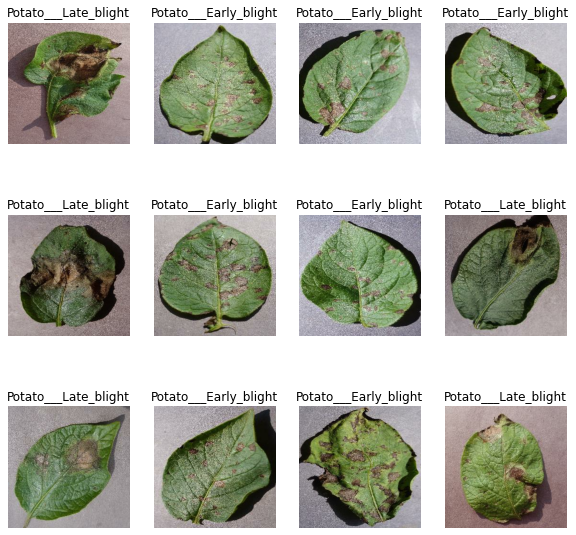

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) #3 ROW 4 COLUMN and i+1th plot
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

#### We will differentiate the data into
#### 80% ==> Training 
#### 20% ==> 10% Validation , 10% Test

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)


In [10]:
test_ds = dataset.skip(54)
print(f"The Length of Train Dataset: {len(train_ds)} and total images in Train is {len(train_ds)*Batch_size}. ")
print(f"The Length of Test Dataset: {len(test_ds)} and total images in Test is {len(test_ds)*Batch_size}. ")

The Length of Train Dataset: 54 and total images in Train is 1728. 
The Length of Test Dataset: 14 and total images in Test is 448. 


In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
len(test_ds.take(6))

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

#### Function to perform Train_Test_Split

In [14]:
def get_dataset_partitions_tf(ds,train_split = 0.8,test_split=0.1,val_split=0.1,shuffle = True,shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=10)
    
    ds_size = len(ds)
    train_size=int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [16]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


#### cache() it will read the image from the disk and once it goes through image then again it will load the image from the memory itself.
#### prefetch() will load a batch and starts its training in GPU till the CPU perform the reading task of next batch.(GPU will train batch 1 when CPU is loading batch 2) 
#### cache is a store of things that may be required in the future, which can be retrieved rapidly, protected or hidden in some way while prefetch is the operation of loading data or instructions in anticipation of their need.


In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### The RGB Values will be between 0 and 255 but we want to scale our data and bring values between 0 and 1 in order to avoid bias and make our Model Robust.  Resize layer is also passed so that the model can give convenient results to the images of different size also.
#### To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### Performing data augmentation for learning deep neural networks is known to be important for training visual recognition systems. By artificially increasing the number of training examples, it helps reducing overfitting and improves generalization.
#### Data Augmentation is used to make our model robust. i.e it can give the convenient results for the rotated as well as contrast Images
#### The generated images aren't generated at the same time, they are generated in batches for flexibility (memory friendly). So the fit happens only on samples of one batch a time. Each epochs fits on almost all train images in the end of training.


In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model Bulding 

#### Here we will be using Convolutional Neural Network in order to classify the Images CNN includes various steps :
    The First Step is to decide the filters which we are going to apply in the case of an Image. Eg:(Ear,Nose,Eye etc for Humans)
    The Second Step Involves application pooling techniques to the created matrix( after extraction of features) in order to get
    better optimize size of matrix.
    The Final Step is to apply the pooled matrix to a neural network and train it to get the desired Output.

The Number of Convolutional and Maxpooling Layer are based on Trial and Error.


In [20]:
input_shape = (Batch_size, img_size, img_size, rgb_channel)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

#### Parameters are Weights we need to backpropogate in order to get the corrected weight. i.e 183,747 are the number of weights

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 [==============================] - 90s 2s/step - loss: 0.8726 - accuracy: 0.5135 - val_loss: 0.7299 - val_accuracy: 0.6562
Epoch 2/30
54/54 [==============================] - 88s 2s/step - loss: 0.5167 - accuracy: 0.7694 - val_loss: 0.3728 - val_accuracy: 0.8281
Epoch 3/30
54/54 [==============================] - 83s 2s/step - loss: 0.3585 - accuracy: 0.8509 - val_loss: 0.2633 - val_accuracy: 0.9062
Epoch 4/30
54/54 [==============================] - 83s 2s/step - loss: 0.3014 - accuracy: 0.8685 - val_loss: 0.3486 - val_accuracy: 0.8385
Epoch 5/30
54/54 [==============================] - 83s 2s/step - loss: 0.2939 - accuracy: 0.8756 - val_loss: 0.3545 - val_accuracy: 0.8385
Epoch 6/30
54/54 [==============================] - 89s 2s/step - loss: 0.2455 - accuracy: 0.9090 - val_loss: 0.2605 - val_accuracy: 0.9010
Epoch 7/30
54/54 [==============================] - 80s 1s/step - loss: 0.2334 - accuracy: 0.9026 - val_loss: 0.1890 - val_accuracy: 0.9167
Epoch 8/30
54/54 [==

In [24]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 4s 310ms/step - loss: 0.1205 - accuracy: 0.9531


[0.12048755586147308, 0.953125]

In [25]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
type(history.history['loss'])

list

In [28]:
len(history.history['loss'])

30

In [29]:
history.history['loss']

[0.8725586533546448,
 0.5166964530944824,
 0.3584844172000885,
 0.3014487028121948,
 0.29389646649360657,
 0.24549205601215363,
 0.2334170639514923,
 0.1787005513906479,
 0.2309771329164505,
 0.15818575024604797,
 0.16848382353782654,
 0.16280589997768402,
 0.13156452775001526,
 0.11191949993371964,
 0.12285365164279938,
 0.13545118272304535,
 0.1237255409359932,
 0.08610302209854126,
 0.056352779269218445,
 0.07517082989215851,
 0.08270855247974396,
 0.12922106683254242,
 0.1279418170452118,
 0.08996102958917618,
 0.06489019840955734,
 0.04664524644613266,
 0.08088631182909012,
 0.06428025662899017,
 0.02898760326206684,
 0.03346311300992966]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

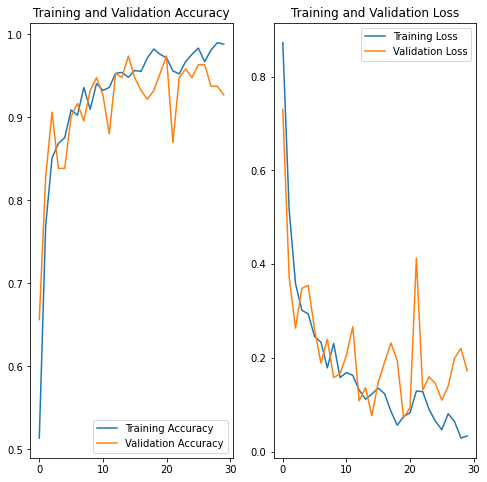

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___healthy
predicted label: Potato___healthy


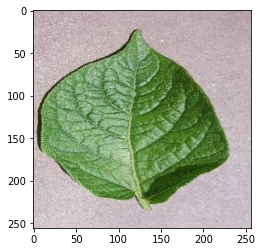

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

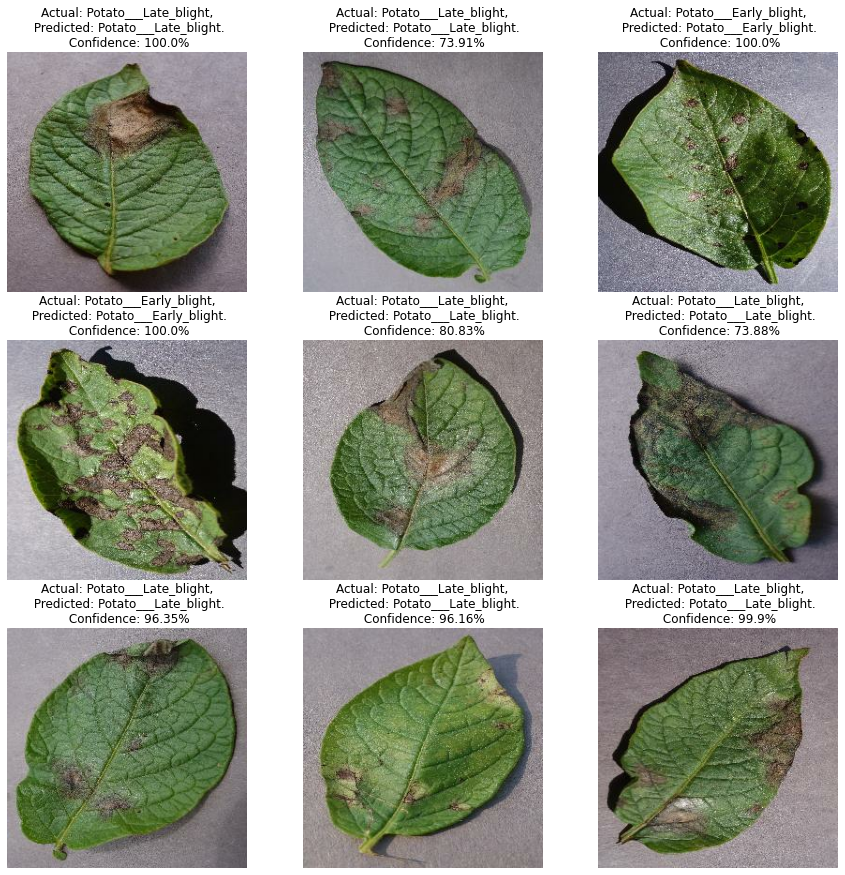

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
model.save('./models', save_format='tf') 

INFO:tensorflow:Assets written to: ./models\assets


In [39]:
tf.keras.models.save_model(model,'my_model2.hdf5')

In [40]:
!pip install streamlit

In [41]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/c/Users/Dell/Desktop/Potato_Leaf_Disease/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Potato Leaf Disease Classification Using Deep Learning by Galav Bhatt
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (256,256)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Writing app.py
